In [3]:
import pandas as pd
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import random
import os
import copy
from scipy.spatial.distance import euclidean
from tqdm import tqdm_notebook

In [4]:
def complete_pipeline(draw=False):
    # Загружаем данные
    data = pd.read_csv('params.txt',sep=' ')
    data.drop(labels=['Unnamed: 25'],inplace=True,axis=1)
    a = random.randint(0,500)
    #Итерируемся по строкам таблицы
    for index, row in tqdm_notebook(data.iterrows()):
        if draw:
            if index<a:
                continue
            print(index)
        img_name = row['Filename']
        # Радужка
        c_x = row['IriX']
        c_y = row['IriY']
        c_r = row['IriR']
        # Зрачок
        cs_x = row['PupX']
        cs_y = row['PupY']
        cs_r = row['PupR']
        # Получаем поле производных
        sobely = preprocess_image(img_name,draw=draw)
        sobely = to_uint8(sobely)
        # Получаем бинарную маску
        th2 = cv2.adaptiveThreshold(sobely,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,15,2)
        # Рисуем
        if draw:
            f = plt.figure(figsize=(15,15))
            f.add_subplot(334),plt.imshow(th2,cmap = 'gray')
            f.show()
        # Создаем маску
        mask = create_elipse_mask(480,640,center = (c_x,c_y),radius = c_r*1.1)
        masked_img = (mask*th2)
        morphology_mask = apply_morphology(masked_img)
        croped_morphology_mask = morphology_mask[:int(cs_y*1),...]
        if draw:
            f = plt.figure(figsize=(15,15))
            f.add_subplot(331),plt.imshow(mask,cmap = 'gray')
            f.add_subplot(332),plt.imshow(masked_img,cmap = 'gray')
            f.add_subplot(333),plt.imshow(croped_morphology_mask,cmap = 'gray')
            f.show()
        # Находим контуры
        im2, contours, hierarchy = cv2.findContours(croped_morphology_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        # Очищаем маску и выбираем точки для параболы
        clean_mask,x,y = remove_noise(croped_morphology_mask,contours,cs_x,cs_y,cs_r)
        # Получаем коэффициенты параболы и картинку с параболой
        poly_coeffs,final_img = create_polynomial(x,y,img_name)
        # Получаем коэффициенты и картинку параболы из файла
        get_groundtruth_parab(row,final_img)
        if draw:
            f = plt.figure(figsize=(15,15))
            f.add_subplot(331),plt.imshow(clean_mask,cmap = 'gray')
            f.add_subplot(332),plt.imshow(final_img)
            f.show()
            break
        else:
            cv2.imwrite('processed_imgs/'+img_name,final_img)
def preprocess_image(img_name,draw=False):
    img0 = cv2.imread('imgs/'+img_name)
    gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    # Медианный фильтр, чтобы убрать лишние градиентные переходы цвета, особенно на ресницах
    img = cv2.medianBlur(gray,25)
    # Поле производных по y
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # Рисуем
    if draw:
        f = plt.figure(figsize=(15,15))
        f.add_subplot(332),plt.imshow(img,cmap = 'gray')
        f.add_subplot(331),plt.imshow(gray,cmap = 'gray')
        f.add_subplot(333),plt.imshow(sobely,cmap = 'gray')
        f.show()
    return sobely
def to_uint8(b):
    # Переводим произвольную матрицу в матрицу цветов с яркостями [0,255]
    a = (b-b.min())*(255/(b-b.min()).max())
    a = a.astype('uint8')
    return a
def create_elipse_mask(h, w, center=None, radius=None):
    # Создаем элиптическую маску для радужки
    Y, X = np.ogrid[:h, :w]
    elips_X_coeff = 0.35
    dist_from_center = np.sqrt(elips_X_coeff*(X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
def apply_morphology(mask):
    # Применяем морфологические функции для уменьшения шумов
    masked_img = copy.copy(mask)
    masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4)))
    #masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1)))
    masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1)))
    return masked_img
def remove_noise(masked_img,contours,cs_x,cs_y,cs_r):
    # Убираем точки, отделяющие зрачок
    clean_mask = np.zeros_like(masked_img,dtype='uint8')
    for group in contours:
        for point in group:
            if euclidean(point[0],(cs_x,cs_y))>cs_r*1.2:
                clean_mask[point[0][1],point[0][0]] = 255
    # для каждой горизонтальной кординаты берем ближайшую к зрачку вертикальную координату
    transposed_mask = clean_mask.T
    y = []
    x = []
    for i in range(len(transposed_mask)):
        am = transposed_mask[i][::-1].argmax()
        if am>0:
            y.append(am+cs_y)
            x.append(i)
    return clean_mask,x,y
def create_polynomial(x,y,img_name):
    # Создаем полином по точкам и строим значения параболы
    poly_coeffs = np.polyfit(x,y,2)
    p = np.poly1d(poly_coeffs)
    xp = np.arange(60,600,1)
    img = cv2.imread('imgs/'+img_name)
    img = cv2.rotate(img,cv2.ROTATE_180)
    for i in xp:
        cv2.circle(img,(i,int(p(i))),2,(255,0,0),-1)
    img = cv2.rotate(img,cv2.ROTATE_180)
    return poly_coeffs,img
def get_groundtruth_parab(row,img):
    # Создаем полином по точкам из файла
    parab = np.array(row[['OPrUpA','OPrUpX','OPrUpY']])
    X = np.arange(60,600,1)
    Y = [get_y(i,parab) for i in X]
    # Рисуем его
    for i in range(len(X)):
        cv2.circle(img,(X[i],int(Y[i])),2,(0,255,0),-1)
def get_y(x,parab):
    y = (parab[0]/(2**20))*((x-parab[1])**2)+parab[2]
    return y

280


C:\Users\Vladimir\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


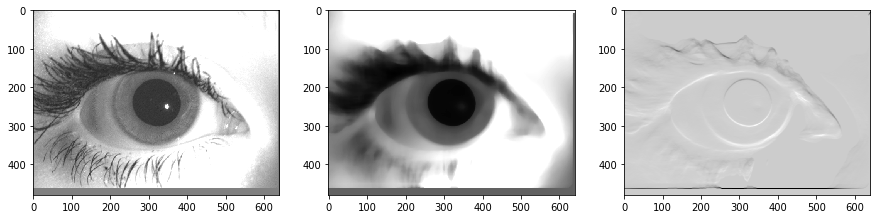

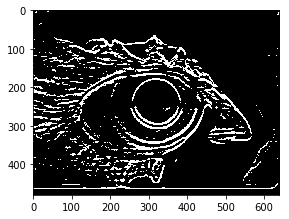

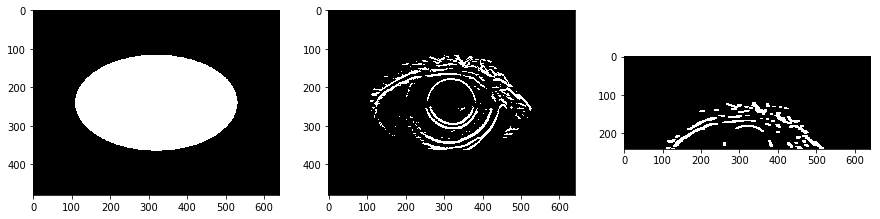

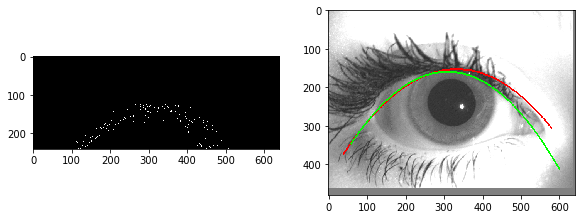

In [7]:
complete_pipeline(draw=True)

# Chernovik

/home/elyha7/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


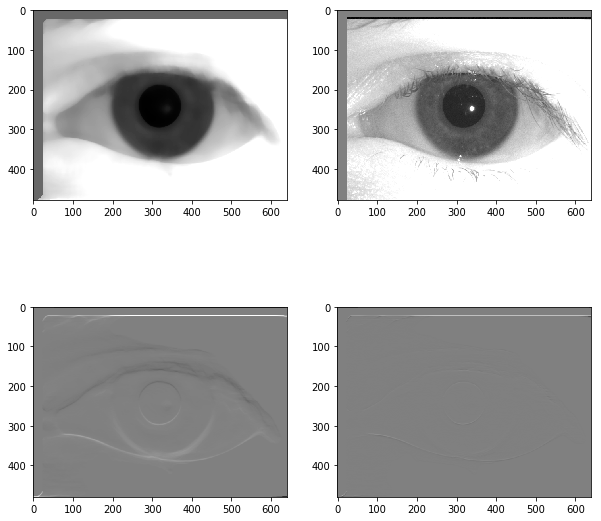

In [423]:
def to_uint8(b):
    a = (b-b.min())*(255/(b-b.min()).max())
    a = a.astype('uint8')
    return a
def preprocess_image():
    img0 = cv2.imread('imgs/'+img_name)
    gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(gray,25)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # x
    f = plt.figure(figsize=(10,10))
    f.add_subplot(2,2,2),plt.imshow(img,cmap = 'gray')
    f.add_subplot(2,2,1),plt.imshow(gray,cmap = 'gray')
    f.add_subplot(2,2,3),plt.imshow(sobely,cmap = 'gray')

    f.show()

In [424]:
a = to_uint8(sobelx)
#a = cv2.GaussianBlur(a,(7,7),0)
#a = cv2.medianBlur(a,7)

In [425]:
ret,th1 = cv2.threshold(a,100,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(a,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,15,2)
th3 = cv2.adaptiveThreshold(a,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,15,2)

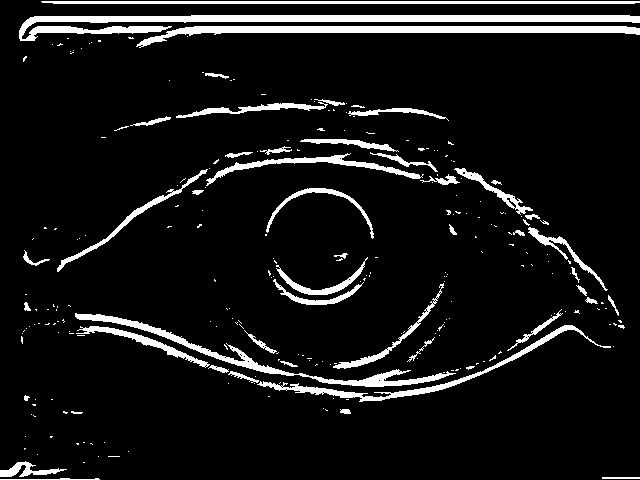

In [426]:
#_ = cv2.circle(th1,(c_x,c_y),c_r,1)
Image.fromarray(th2)

In [532]:
def createCircularMask(h, w, center=None, radius=None):
    # Создаем элиптическую маску для радужки
    Y, X = np.ogrid[:h, :w]
    elips_X_coeff = 0.6
    dist_from_center = np.sqrt(elips_X_coeff*(X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [533]:
mask = createCircularMask(480,640,center = (c_x,c_y),radius = c_r*1.2)

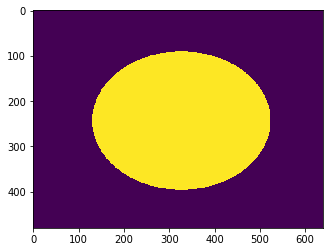

In [534]:
plt.imshow(mask)

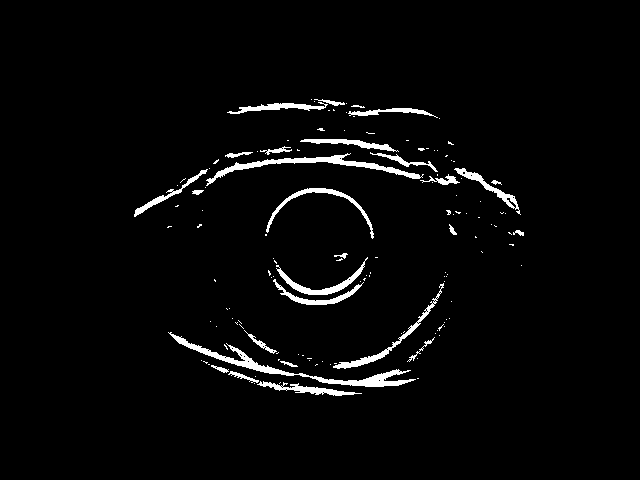

In [507]:
masked_img = (mask*th2)
Image.fromarray(masked_img)

In [508]:
masked_img = (mask*th2)
#masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,3)))
masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4)))
masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1)))
# masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,1)))
# masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)))
# masked_img = cv2.morphologyEx(masked_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

In [509]:
masked_img = masked_img[:int(cs_y*1),...]

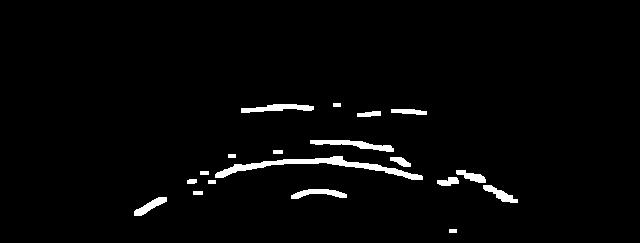

In [510]:
Image.fromarray(masked_img)

In [511]:
masked_img.shape

(243, 640)

In [512]:
im2, contours, hierarchy = cv2.findContours(masked_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [564]:
clean_list = np.zeros_like(masked_img,dtype='uint8')
for group in contours:
    for point in group:
        if euclidean(point[0],(cs_x,cs_y))>cs_r*1.2:
            clean_list[point[0][1],point[0][0]] = 255

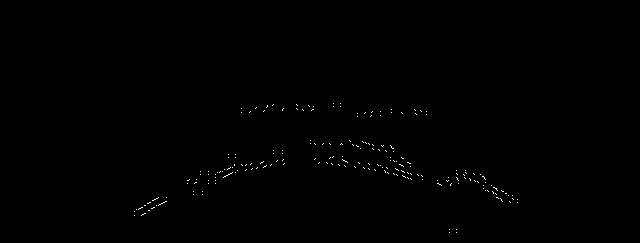

In [565]:
Image.fromarray(clean_list)

In [513]:
# def get_balanced_radius(mask,cs_x,cs_y,cs_r):
#     distances = []
#     for y in range(mask.shape[0]):
#         for x in range(mask.shape[1]):
#             if mask[y][x]>0:
#                 dist = euclidean((x,y),(cs_x,cs_y))
#             if dist<cs_r*1.2:
#                 mask[y][x] = 0
#             else:

In [514]:
haract = []
for group in contours:
    a = {'mean_y':0,'mean_x':0,'x_range':[0,0]}
    a['mean'] = group[0].mean(axis=0)
    a['x_range'][0] = group[0].min(axis=0)[1]
    a['x_range'][1] = group[0].max(axis=0)[1]
    a['values'] = group
    haract.append(a)

In [515]:
from scipy.spatial.distance import euclidean

In [516]:
good_list = []
for num,i in enumerate(haract):
    if euclidean(i['mean'],(cs_x,cs_y))>cs_r*1.2:
        good_list.append(i)

In [517]:
clean_list = np.zeros_like(masked_img,dtype='uint8')

In [518]:
y =[]
for i in good_list:
    for j in i['values']:
        clean_list[j[0][1]][j[0][0]] = 255

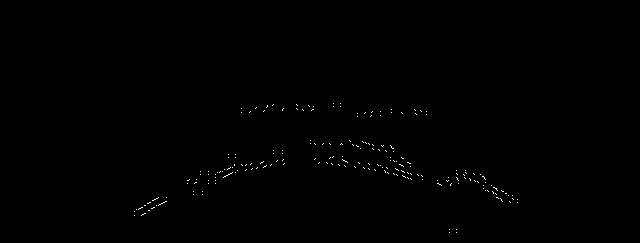

In [519]:
Image.fromarray(clean_list)

In [520]:
clean_list.shape

(243, 640)

In [521]:
len([i for i in clean_list.flatten() if i!=0])

399

In [522]:
len([i for i in transposed_img.flatten() if i!=0])

408

In [566]:
transposed_img = clean_list.T

In [567]:
y = []
x = []
for i in range(len(transposed_img)):
    am = transposed_img[i][::-1].argmax()
    if am>0:
        y.append(am+cs_y)
        x.append(i)

In [525]:
z = np.polyfit(x,y,2)

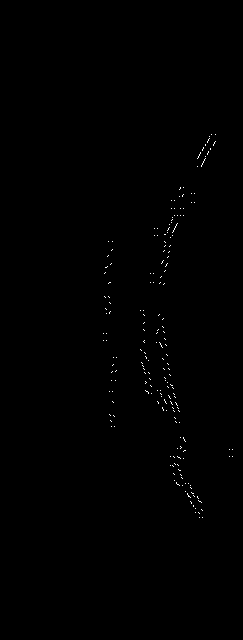

In [568]:
Image.fromarray(transposed_img)

In [528]:
p = np.poly1d(z)

(0, 640)

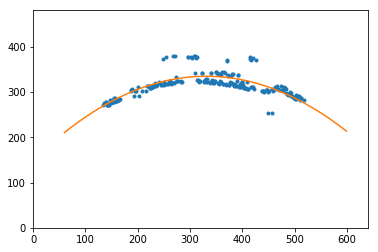

In [529]:

_ = plt.plot(x, y, '.', xp, p(xp), '-')
plt.ylim(0,480)
plt.xlim(0,640)

In [530]:
xp = np.arange(60,600,1)
gray1 = cv2.rotate(img0,cv2.ROTATE_180)
for i in xp:
    cv2.circle(gray1,(i,int(p(i))),2,(255,0,0),-1)
gray1 = cv2.rotate(gray1,cv2.ROTATE_180)

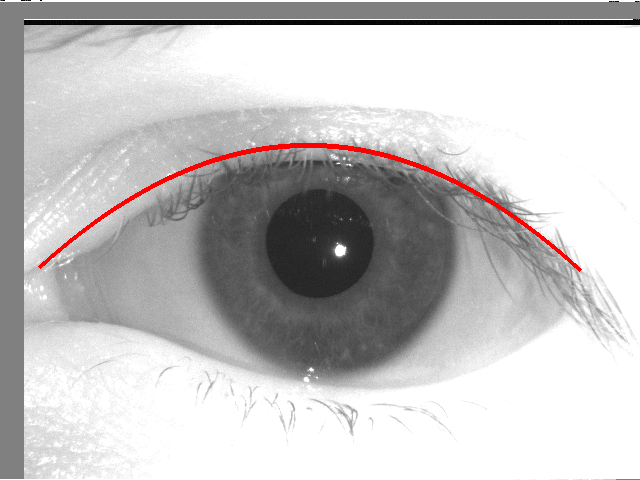

In [531]:
Image.fromarray(gray1)